# 二項分布モデルの場合の通常の検定と事後分布の比較

* 黒木玄
* 2022-08-12～2022-08-13
$
\newcommand\op{\operatorname}
\newcommand\cdf{\op{cdf}}
\newcommand\ccdf{\op{ccdf}}
\newcommand\pdf{\op{pdf}}
\newcommand\mode{\op{mode}}
\newcommand\hdi{\op{hdi}}
\newcommand\quantile{\op{quantile}}
\newcommand\confint{\op{confint}}
\newcommand\credint{\op{credint}}
\newcommand\pvalue{\op{pvalue}}
\newcommand\Beta{\op{Beta}}
\newcommand\Binomial{\op{Binomial}}
\newcommand\Chisq{\op{Chisq}}
\newcommand\Normal{\op{Normal}}
\newcommand\post{\op{post}}
\newcommand\normal{\op{normal}}
\newcommand\llr{\op{LLR}}
\newcommand\pearson{\op{Pearson}}
\newcommand\bayesian{\op{Bayesian}}
\newcommand\phat{\hat{p}}
\newcommand\SE{\op{SE}}
\newcommand\SEhat{\widehat{\SE}}
$

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#解説" data-toc-modified-id="解説-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>解説</a></span><ul class="toc-item"><li><span><a href="#二項分布モデル" data-toc-modified-id="二項分布モデル-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>二項分布モデル</a></span></li><li><span><a href="#事後分布" data-toc-modified-id="事後分布-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>事後分布</a></span></li><li><span><a href="#対数尤度比のχ²検定" data-toc-modified-id="対数尤度比のχ²検定-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>対数尤度比のχ²検定</a></span></li><li><span><a href="#Pearsonのχ²検定" data-toc-modified-id="Pearsonのχ²検定-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Pearsonのχ²検定</a></span></li></ul></li><li><span><a href="#比較" data-toc-modified-id="比較-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>比較</a></span></li></ul></div>

In [1]:
using Distributions
using Memoization
using Optim
using QuadGK
using Roots
using SpecialFunctions
using StatsBase
using StatsFuns
using StatsPlots
default(size=(500, 280), titlefontsize=10, tickfontsize=6, guidefontsize=9)

safemul(x, y) = x == 0 ? x : x*y
safediv(x, y) = x == 0 ? x : x/y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
"""
    hdi(dist::ContinuousUnivariateDistribution, α = 0.05; alg = Brent())

returns the 100(1 - `α`)% highest density interval (HDI) of the distribution `dist`.

Assumption: `dist` is a unimodal continuous univariate distribution.
"""
function hdi(dist::ContinuousUnivariateDistribution, α = 0.05; alg = Brent())
    f(p) = quantile(dist, p + (1 - α)) - quantile(dist, p)
    o = optimize(f, 0, α, alg)
    p = o.minimizer
    quantile.(dist, (p, p + (1 - α)))
end

@doc hdi

```
hdi(dist::ContinuousUnivariateDistribution, α = 0.05; alg = Brent())
```

returns the 100(1 - `α`)% highest density interval (HDI) of the distribution `dist`.

Assumption: `dist` is a unimodal continuous univariate distribution.


In [3]:
"""
    invpdf(dist, y; alg = Order0(), modefunc = mymode)

returns the tuple of the left-side and right-side inverses of pdf at y.

Assumption: `dist` is a unimodal continuous univariate distribution.
"""
function invpdf(dist::ContinuousUnivariateDistribution, y;
        alg = Order0(), modefunc = mymode, h = 0.01)
    m = modefunc(dist)
    σ = std(dist)
    cdfm = cdf(dist, m)
    a0 = quantile(dist, max(minimum(dist), cdfm - h*σ))
    b0 = quantile(dist, min(maximum(dist), cdfm + h*σ))
    f(x) = logpdf(dist, x) - log(y)
    a = m == minimum(dist) ? minimum(dist) : find_zero(f, a0, alg)
    b = m == maximum(dist) ? maximum(dist) : find_zero(f, b0, alg)
    a, b
end

"""
    mymode(x)

An appropriate corrected version of `mode(x)`.
"""
mymode(x) = mode(x)

function mymode(beta::Beta)
    α, β = params(beta)
    α == 1 && β == 1 && return median(beta)
    α == 1 && β > 1 && return mininmum(beta)
    α > 1 && β == 1 && return maximum(beta)
    mode(beta)
end

@doc invpdf

```
invpdf(dist, y; alg = Order0(), modefunc = mymode)
```

returns the tuple of the left-side and right-side inverses of pdf at y.

Assumption: `dist` is a unimodal continuous univariate distribution.


## 解説

### 二項分布モデル

$$
P(k|n, p) = \binom{n}{k} p^k (1-p)^{n-k} \quad (k=0,1,2,\ldots,n).
$$

### 事後分布

事前分布が $\Beta(\gamma, \delta)$ のときの, 「$n$ 回中 $k$ 回当たり」というデータに関する事後分布は

$$
\post = \Beta(k+\gamma, (n-k)+\delta)
$$

になる.  $100(1-\alpha)\%$ 信用区間をこの事後分布のHDI (highest density interval)として定める:

$$
\credint(k|n,\alpha) = \hdi(\post, \alpha).
$$

ここで, $\hdi(\post, \alpha) = [p_L, p_U]$ のとき,

$$
\pdf(\post, p_L) = \pdf(\post, p_U), \quad
\cdf(\post, p_U) - \cdf(\post, p_U) = 1 - \alpha
$$

であり, この条件で $\hdi(\post, \alpha)$ は一意に特徴付けられる.

この信用区間に対応するという「当たりが出る確率は $p$ である」という仮説に関するP値函数を以下のように定めることができる:

$$
\pvalue_{\bayesian}(k|n,p) = \cdf(\post, a) + (1 - \cdf(\post b)).
$$

ここで, $a$, $b$ は

$$
\pdf(\post, a) = \pdf(\post, b) = \pdf(\post, p), \quad a < b
$$

を満たす $a,b\in[0,1]$ である.

In [4]:
posterior(n, k, γ=1, δ=γ) = Beta(k+γ, n-k+δ)

function credint(n, k; α = 0.05, γ = 1, δ = γ)
    post = posterior(n, k, γ, δ)
    hdi(post, α) |> collect
end

function pvalue_bayesian(n, k, p; γ = 1, δ = γ)
    post = posterior(n, k, γ, δ)
    a, b = invpdf(post, pdf(post, p))
    cdf(post, a) + ccdf(post, b)
end

pvalue_bayesian (generic function with 1 method)

pval_bayes = pvalue_bayesian(n, k, 0.6) = 0.005076957886645475
ci_bayes = credint(n, k) = [0.13606948377291903, 0.5092998691378794]
post = posterior(n, k) = Beta{Float64}(α=7.0, β=15.0)


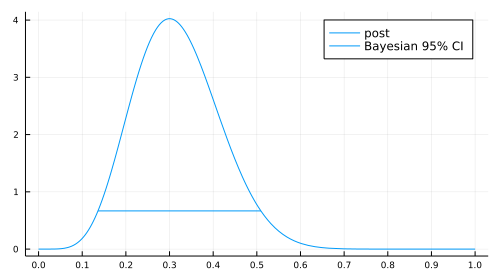

In [5]:
n, k = 20, 6
@show pval_bayes = pvalue_bayesian(n, k, 0.6)
@show ci_bayes = credint(n, k)
@show post = posterior(n, k)

plot(p -> pdf(post, p), 0, 1; label="post", c=1)
plot!(ci_bayes, fill(pdf(post, ci_bayes[begin]), 2);
    label="Bayesian 95% CI", c=1)
plot!(xtick=0:0.1:1)

### 対数尤度比のχ²検定

「$n$ 回中 $k$ 回当たり」というデータと「当たりの確率は $p$ である」という仮説について

$$
\chi^2_{\llr} = 2\log\frac{P(k|n, k/n)}{P(k|n,p)} =
2\left(k\log\frac{k/n}{p} + (n-k)\log\frac{1-k/n}{1-p}\right)
$$

とおき, P値を次のように定める:

$$
\pvalue_{\llr}(k|n,p) = 1 - \cdf(\Chisq(1), \chi^2_{\llr}).
$$

この条件に関する信頼度 $1-\alpha$ の信頼区間

$$
\confint_{\llr}(k|n,\alpha) = \{\, p\in[0,1]\mid \pvalue_{\llr}(k|n,p) \ge \alpha\,\}
$$

は以下のように書き直される.  まず,

$$
z_{\alpha/2} = \quantile(\Normal(0, 1), 1 - \alpha/2)
$$

とおく.  このとき, $z_{\alpha/2}^2 = \quantile(\Chisq(1), 1-\alpha)$ が成立している.  さらに

$$
\post_0 = \Beta(k+1, (n-k)+1)
$$

とおくと, 

$$
\exp\left(-\chi^2_{\llr}\big/2\right) =
\frac{P(k|n,p)}{P(k|n,k/n)} =
\frac{\pdf(\post_0, p)}{\pdf(\post_0, k/n)}.
$$

ゆえに

$$
p \in \confint_{\llr}(k|n,\alpha)
\iff
\pdf(\post_0, p) \le \exp\left(-z_{\alpha/2}^2\big/2\right) \pdf(\post_0, k/n).
$$

したがって, 

$$
\pdf(\post_0, p) = \exp\left(-z_{\alpha/2}^2\big/2\right) \pdf(\post_0, k/n)
$$

を満たす $p$ を小さい順に $p_L$, $p_U$ とすると,

$$
\confint_{\llr}(k|n,\alpha) = [p_L, p_U].
$$

In [6]:
function chisq_llr(n, k, p)
    2(xlogy(k, safediv(k/n, p)) + xlogy(n-k, safediv(1-k/n, 1-p)))
end

function pvalue_llr(n, k, p)
    ccdf(Chisq(1), chisq_llr(n, k, p))
end

function confint_llr(n, k; α = 0.05)
    post0 = posterior(n, k)
    z = quantile(Normal(), 1-α/2)
    invpdf(post0, exp(-z^2/2) * pdf(post0, k/n)) |> collect
end

confint_llr (generic function with 1 method)

pval_llr = pvalue_llr(n, k, 0.6) = 0.006700772503495723
ci_llr = confint_llr(n, k) = [0.13178187016757775, 0.5165046145299313]
post0 = posterior(n, k) = Beta{Float64}(α=7.0, β=15.0)


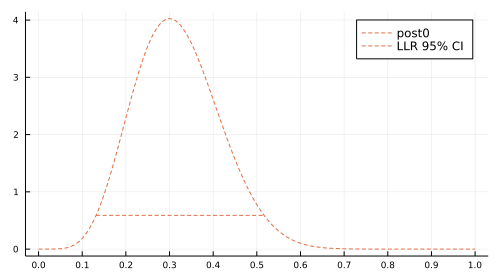

In [7]:
n, k = 20, 6
@show pval_llr = pvalue_llr(n, k, 0.6)
@show ci_llr = confint_llr(n, k)
@show post0 = posterior(n, k)

plot(p -> pdf(post0, p), 0, 1; label="post0", c=2, ls=:dash)
plot!(ci_llr, fill(pdf(post0, ci_llr[begin]), 2);
    label="LLR 95% CI", c=2, ls=:dash)
plot!(xtick=0:0.1:1)

### Pearsonのχ²検定

「$n$ 回中 $k$ 回当たり」というデータと「当たりの確率は $p$ である」という仮説について

$$
\chi^2_{\pearson} = \frac{(k - np)^2}{np(1-p)} =
\frac{(p - k/n)^2}{p(1-p)/n}
$$

とおき, P値を次のように定める:

$$
\pvalue_{\pearson}(k|n,p) = 1 - \cdf(\Chisq(1), \chi^2_{\pearson}).
$$

この条件に関する信頼度 $1-\alpha$ の信頼区間が次のように定義される:

$$
\confint_{\pearson}(k|n,\alpha) = \{\, p\in[0,1]\mid \pvalue_{\pearson}(k|n,p) \ge \alpha\,\}.
$$

前節と同様に

$$
z_{\alpha/2} = \quantile(\Normal(0, 1), 1 - \alpha/2)
$$

とおく. このとき, $z_{\alpha/2}^2 = \quantile(\Chisq(1), 1-\alpha)$ が成立している. さらに, $p$ に関する2次方程式

$$
(p - k/n)^2 = z_{\alpha/2}^2\,p(1-p)/n
\iff \left(1 + \frac{z^2}{n}\right)p^2 -2\left(\phat + \frac{z^2}{2n}\right)p + \phat^2 = 0
$$

の解として $p_- < p_+$ を求める:

$$
p_\pm = \frac{b \pm \sqrt{b^2-ac}}{a} =
\frac{1}{1+z^2/n}\left(
\phat+\frac{z^2}{2n}
\pm z\sqrt{\SEhat^2 + \frac{z^2}{4n^2}}
\right).
$$

ここで

$$
\begin{aligned}
&
z = z_{\alpha/2}, \quad \phat = \frac{k}{n}, \quad \SEhat^2 = \frac{\phat(1-\phat)}{n},
\\ &
a = 1 + \frac{z^2}{n}, \quad
b = \phat + \frac{z^2}{2n}, \quad
c = \phat^2.
\end{aligned}
$$

このとき,

$$
\confint_{\pearson}(k|n,\alpha) = [p_-, p_+].
$$

区間 $[0, 1]$ 上の確率密度函数 $f(p)$ を次のように定める:

$$
f(p) \propto \exp\left(-\frac{1}{2}\chi^2_{\pearson}\right) =
\exp\left(-\frac{1}{2}\frac{(p - k/n)^2}{p(1-p)/n}\right)
$$

これは $p=k/n$ で最大になるので,

$$
\exp\left( -\chi^2_{\pearson} \big/2 \right) = \frac{f(p)}{f(k/n)}.
$$

ゆえに

$$
p \in \confint_{\pearson}(k|n,\alpha)
\iff
f(p) \le \exp\left(-z_{\alpha/2}^2\big/2\right) f(k/n).
$$

したがって, 

$$
f(p) = \exp\left(-z_{\alpha/2}^2\big/2\right) f(k/n)
$$

を満たす $p$ は上の $p_\pm$ に一致する.

以上の方法は二項分布モデルの場合のWilsonのスコア検定と同等である.  上の方法で得られた信頼区間はWilsonの信頼区間と呼ばれる.  沢山ある信頼区間の定義の中で, Wilsonの信頼区間はかなり無難な方の選択しだと考えられる.

In [8]:
@memoize function Z_pearson(n, k)
    quadgk(p -> exp(-chisq_pearson(n, k, p)/2), 0, 1)[1]
end

function pdf_pearson(n, k, p)
    exp(-chisq_pearson(n, k, p)/2) / Z_pearson(n, k)
end

function chisq_pearson(n, k, p)
    safediv((k - n*p)^2, n*p*(1-p))
end

function pvalue_pearson(n, k, p)
    ccdf(Chisq(1), chisq_pearson(n, k, p))
end

function confint_pearson(n, k; α = 0.05)
    p̂ = k/n
    z = quantile(Normal(), 1-α/2)
    a, b, c = 1+z^2/n, p̂+z^2/(2n), p̂^2
    sqrtD = √(b^2 - a*c)
    p_L = (b - sqrtD)/a
    p_U = (b + sqrtD)/a
    [p_L, p_U]
end

confint_pearson (generic function with 1 method)

pval_pearson = pvalue_pearson(n, k, 0.6) = 0.006169899320544167
ci_pearson = confint_pearson(n, k) = [0.14547724486760408, 0.5189728183535237]


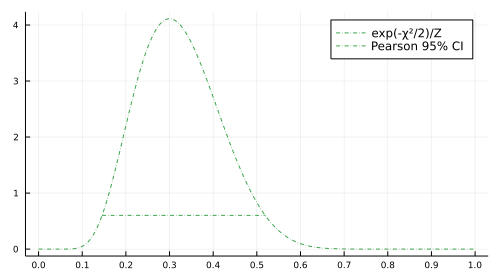

In [9]:
n, k = 20, 6
@show pval_pearson = pvalue_pearson(n, k, 0.6)
@show ci_pearson = confint_pearson(n, k)

plot(p -> pdf_pearson(n, k, p), 0, 1; label="exp(-χ²/2)/Z", c=3, ls=:dashdot)
plot!(ci_pearson, fill(pdf_pearson(n, k, ci_pearson[begin]), 2);
    label="Pearson 95% CI", c=3, ls=:dashdot)
plot!(xtick=0:0.1:1)

## 比較

In [10]:
function plot_paramdist(; n=20, k=6, α=0.05, γ=1, δ=1, kwargs...)
    @show n, k
    println("prior = ($γ, $δ)")
    println()
    @show post = posterior(n, k, γ, δ)
    @show post0 = posterior(n, k)
    println()
    @show ci_bayes____ = credint(n, k; α, γ, δ)
    @show ci_llr________ = confint_llr(n, k; α)
    @show ci_pearson = confint_pearson(n, k; α)
    ci_bayes = ci_bayes____
    ci_llr = ci_llr________
    println()
    @show h_bayes____________ = pdf(post, ci_bayes[begin])
    @show h_llr_______________ = pdf(post0, ci_llr[begin])
    @show h_pearson = pdf_pearson(n, k, ci_pearson[begin])
    println()

    plot(p -> pdf(post, p), 0, 1; label="post", c=1)
    plot!(p -> pdf(post0, p), 0, 1; label="post0", c=2, ls=:dash)
    plot!(p -> pdf_pearson(n, k, p), 0, 1; label="exp(-χ²/2)/Z", c=3, ls=:dashdot)
    plot!(ci_bayes____, fill(h_bayes____________, 2);
        label="Bayesian CI", c=1)
    plot!(ci_llr________, fill(h_llr_______________, 2);
        label="LLR CI", c=2, ls=:dash)
    plot!(ci_pearson, fill(h_pearson, 2);
        label="Pearson CI", c=3, ls=:dashdot)
    plot!(xtick=0:0.05:1, xguide="p", yguide="probability density")
    title!("n=$n, k=$k, α=$α, prior=($γ, $δ)")
    plot!(size=(640, 400))
    plot!(; kwargs...)
end

plot_paramdist (generic function with 1 method)

(n, k) = (10, 3)
prior = (1, 1)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=4.0, β=8.0)
post0 = posterior(n, k) = Beta{Float64}(α=4.0, β=8.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.09337233320249291, 0.5879525593275807]
ci_llr________ = confint_llr(n, k; α) = [0.08455865498150957, 0.6065390309044857]
ci_pearson = confint_pearson(n, k; α) = [0.10779126740630085, 0.6032218525388552]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 0.5410424489230987
h_llr_______________ = pdf(post0, ci_llr[begin]) = 0.4299934016915718
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 0.4463728523702678



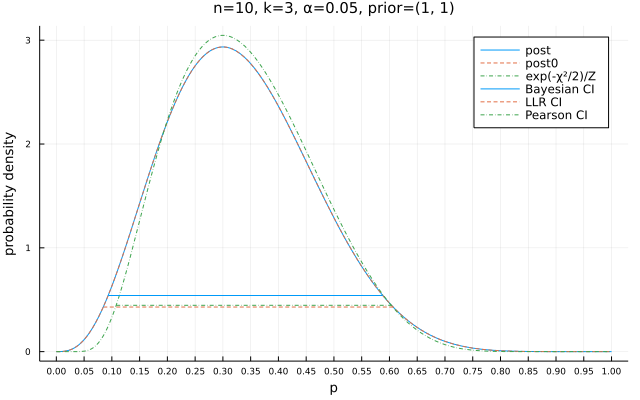

In [11]:
plot_paramdist(n=10, k=3)

(n, k) = (20, 6)
prior = (1, 1)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=7.0, β=15.0)
post0 = posterior(n, k) = Beta{Float64}(α=7.0, β=15.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.13606948377291903, 0.5092998691378794]
ci_llr________ = confint_llr(n, k; α) = [0.13178187016757775, 0.5165046145299313]
ci_pearson = confint_pearson(n, k; α) = [0.14547724486760408, 0.5189728183535237]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 0.6666085677797724
h_llr_______________ = pdf(post0, ci_llr[begin]) = 0.5895775899599626
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 0.6026207800228047



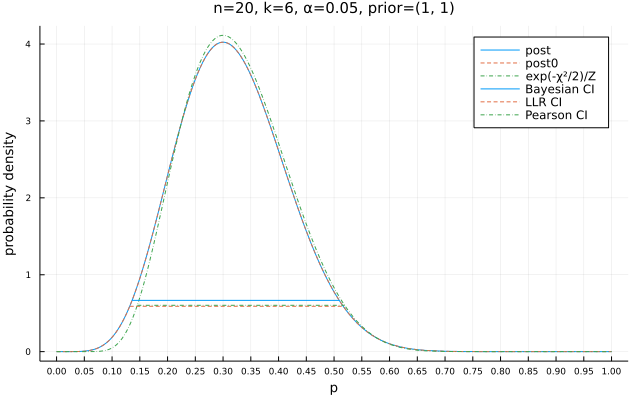

In [12]:
plot_paramdist(n=20, k=6)

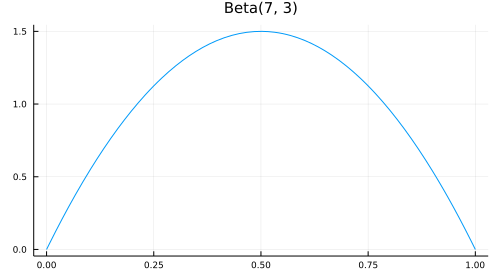

In [13]:
pri = Beta(2, 2)
plot(pri; label="", title="Beta(7, 3)")

(n, k) = (10, 3)
prior = (2, 2)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=5.0, β=9.0)
post0 = posterior(n, k) = Beta{Float64}(α=4.0, β=8.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.12631211200867118, 0.5986930199674054]
ci_llr________ = confint_llr(n, k; α) = [0.08455865498150957, 0.6065390309044857]
ci_pearson = confint_pearson(n, k; α) = [0.10779126740630085, 0.6032218525388552]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 0.5561335035239423
h_llr_______________ = pdf(post0, ci_llr[begin]) = 0.4299934016915718
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 0.4463728523702678



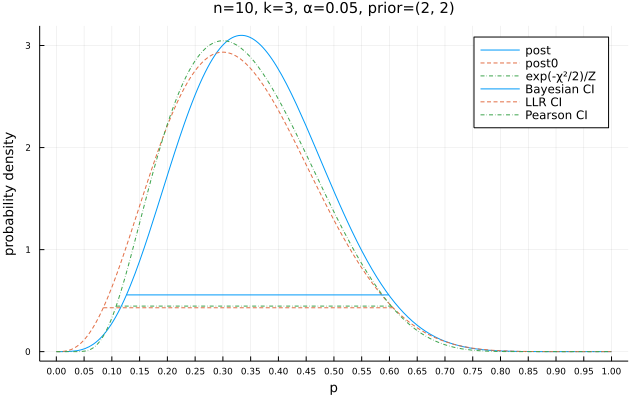

In [14]:
plot_paramdist(n=10, k=3, γ=2, δ=2)

(n, k) = (20, 6)
prior = (2, 2)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=8.0, β=16.0)
post0 = posterior(n, k) = Beta{Float64}(α=7.0, β=15.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.1553517836692004, 0.5188693170375873]
ci_llr________ = confint_llr(n, k; α) = [0.13178187016757775, 0.5165046145299313]
ci_pearson = confint_pearson(n, k; α) = [0.14547724486760408, 0.5189728183535237]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 0.6806377427039582
h_llr_______________ = pdf(post0, ci_llr[begin]) = 0.5895775899599626
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 0.6026207800228047



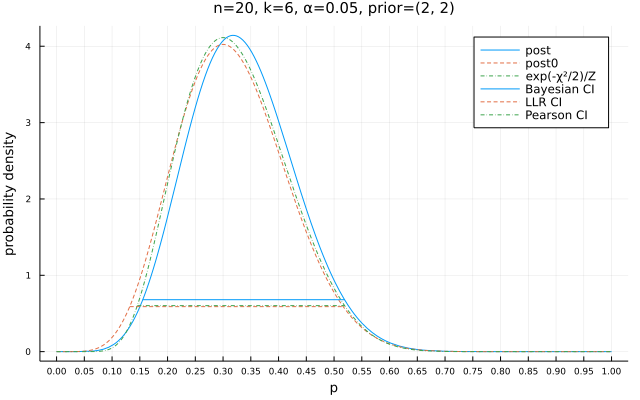

In [15]:
plot_paramdist(n=20, k=6, γ=2, δ=2)

(n, k) = (40, 12)
prior = (2, 2)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=14.0, β=30.0)
post0 = posterior(n, k) = Beta{Float64}(α=13.0, β=29.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.18566596245521286, 0.45526627850974455]
ci_llr________ = confint_llr(n, k; α) = [0.17347678739685704, 0.45138711478041044]
ci_pearson = confint_pearson(n, k; α) = [0.18074845229746514, 0.4543001881814495]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 0.8853650883444705
h_llr_______________ = pdf(post0, ci_llr[begin]) = 0.8203310145288117
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 0.8302021460250971



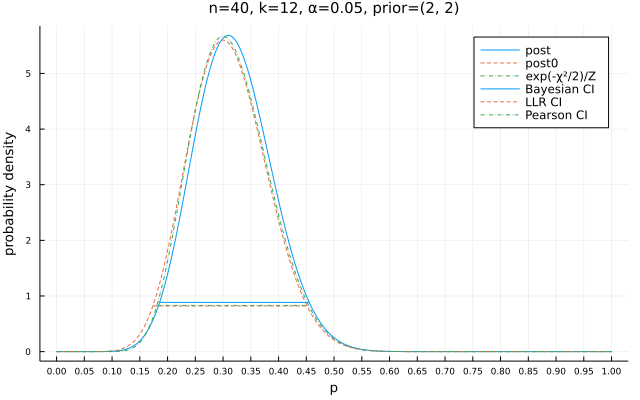

In [16]:
plot_paramdist(n=40, k=12, γ=2, δ=2)

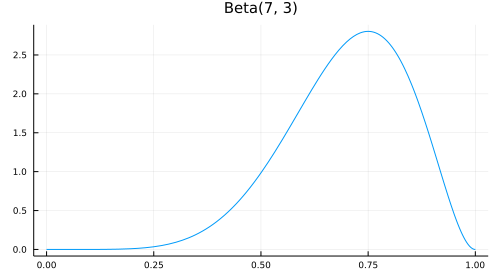

In [17]:
pri = Beta(7, 3)
plot(pri; label="", title="Beta(7, 3)")

(n, k) = (10, 5)
prior = (7, 3)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=12.0, β=8.0)
post0 = posterior(n, k) = Beta{Float64}(α=6.0, β=6.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.39083295220593023, 0.8038484973189935]
ci_llr________ = confint_llr(n, k; α) = [0.21761377050431033, 0.7823862294956896]
ci_pearson = confint_pearson(n, k; α) = [0.23659309051256366, 0.7634069094874364]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 0.6117388887940808
h_llr_______________ = pdf(post0, ci_llr[begin]) = 0.3965802526908431
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 0.4167091207470165



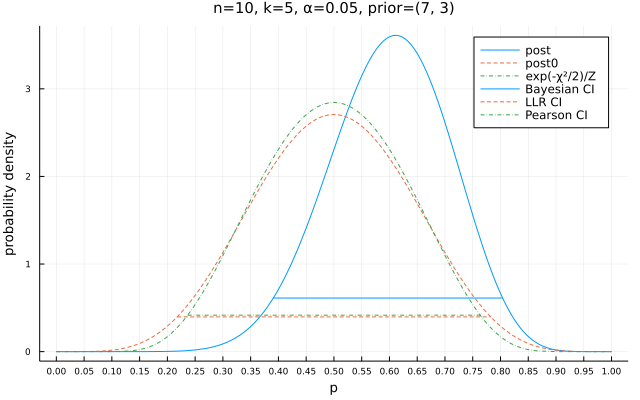

In [18]:
plot_paramdist(n=10, k=5, γ=7, δ=3)

(n, k) = (20, 10)
prior = (7, 3)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=17.0, β=13.0)
post0 = posterior(n, k) = Beta{Float64}(α=11.0, β=11.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.3924752108754098, 0.7384528972727252]
ci_llr________ = confint_llr(n, k; α) = [0.2909824600363462, 0.7090175399636538]
ci_pearson = confint_pearson(n, k; α) = [0.299298008198212, 0.7007019918017879]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 0.7068805079253131
h_llr_______________ = pdf(post0, ci_llr[begin]) = 0.5420704690914208
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 0.5584540168220425



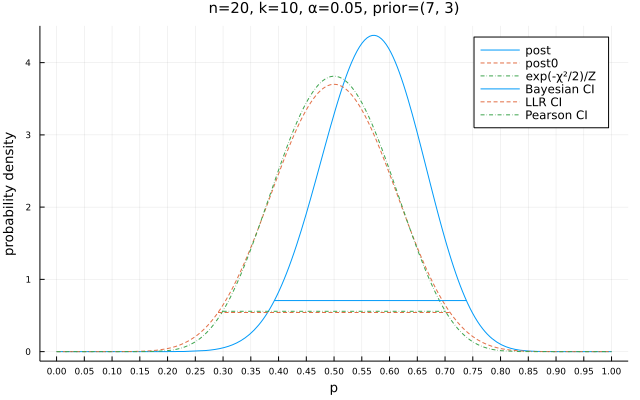

In [19]:
plot_paramdist(n=20, k=10, γ=7, δ=3)

(n, k) = (40, 20)
prior = (7, 3)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=27.0, β=23.0)
post0 = posterior(n, k) = Beta{Float64}(α=21.0, β=21.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.4033991530787962, 0.6757219743295877]
ci_llr________ = confint_llr(n, k; α) = [0.3486980539783188, 0.6513019460216811]
ci_pearson = confint_pearson(n, k; α) = [0.3519952693346535, 0.6480047306653465]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 0.8747296047161024
h_llr_______________ = pdf(post0, ci_llr[begin]) = 0.7530393666582551
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 0.7656276464693489



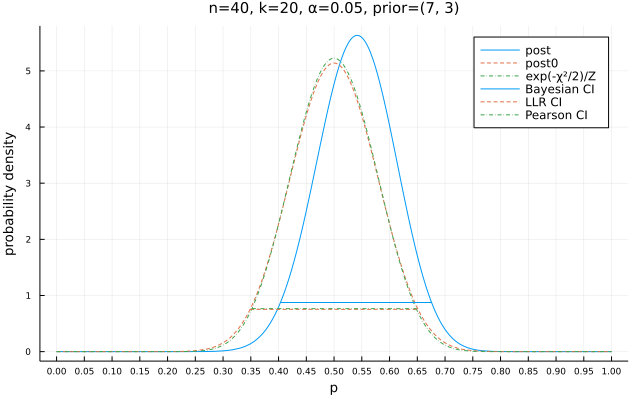

In [20]:
plot_paramdist(n=40, k=20, γ=7, δ=3)

(n, k) = (80, 40)
prior = (7, 3)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=47.0, β=43.0)
post0 = posterior(n, k) = Beta{Float64}(α=41.0, β=41.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.41970550459317385, 0.6244650472601753]
ci_llr________ = confint_llr(n, k; α) = [0.39173690217208496, 0.6082630978279151]
ci_pearson = confint_pearson(n, k; α) = [0.3929741508611971, 0.6070258491388029]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 1.1432334151238817
h_llr_______________ = pdf(post0, ci_llr[begin]) = 1.055263137974024
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 1.064584720918657



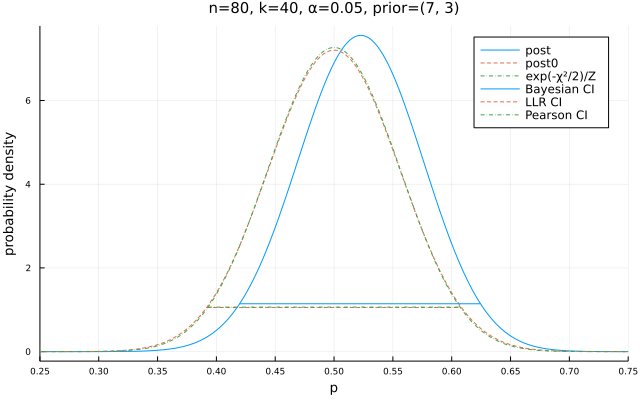

In [21]:
plot_paramdist(n=80, k=40, γ=7, δ=3, xlim=(0.25, 0.75))

(n, k) = (160, 80)
prior = (7, 3)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=87.0, β=83.0)
post0 = posterior(n, k) = Beta{Float64}(α=81.0, β=81.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.4369000172252296, 0.5865522075570244]
ci_llr________ = confint_llr(n, k; α) = [0.42298832618891347, 0.5770116738110865]
ci_pearson = confint_pearson(n, k; α) = [0.4234392476991225, 0.5765607523008776]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 1.5483694741096574
h_llr_______________ = pdf(post0, ci_llr[begin]) = 1.4854744327258729
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 1.4922294772199283



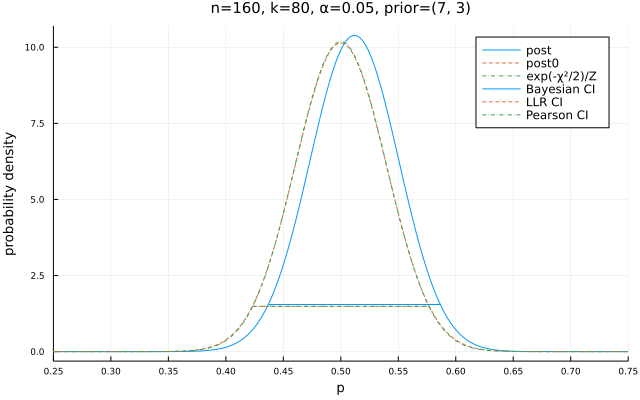

In [22]:
plot_paramdist(n=160, k=80, γ=7, δ=3, xlim=(0.25, 0.75))

(n, k) = (320, 160)
prior = (7, 3)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=167.0, β=163.0)
post0 = posterior(n, k) = Beta{Float64}(α=161.0, β=161.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.4522242111801903, 0.5598764576892659]
ci_llr________ = confint_llr(n, k; α) = [0.4453813411835735, 0.5546186588164265]
ci_pearson = confint_pearson(n, k; α) = [0.4455432308355753, 0.5544567691644247]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 2.1406092382203346
h_llr_______________ = pdf(post0, ci_llr[begin]) = 2.095890690276025
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 2.1007282049118268



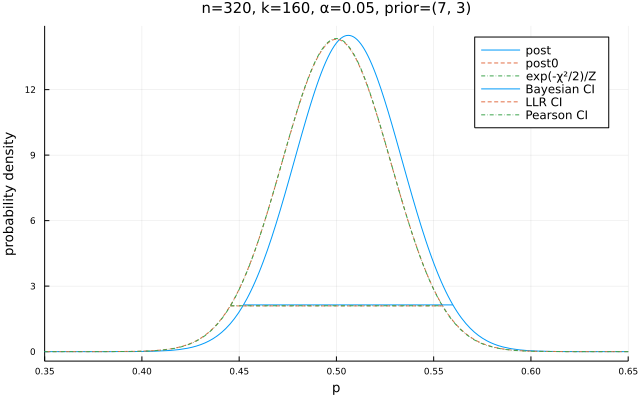

In [23]:
plot_paramdist(n=320, k=160, γ=7, δ=3, xlim=(0.35, 0.65))

(n, k) = (640, 320)
prior = (7, 3)

post = posterior(n, k, γ, δ) = Beta{Float64}(α=327.0, β=323.0)
post0 = posterior(n, k) = Beta{Float64}(α=321.0, β=321.0)

ci_bayes____ = credint(n, k; α, γ, δ) = [0.4646789526602805, 0.541469589872815]
ci_llr________ = confint_llr(n, k; α) = [0.4613208657176752, 0.5386791342823248]
ci_pearson = confint_pearson(n, k; α) = [0.46137854545303136, 0.5386214545469686]

h_bayes____________ = pdf(post, ci_bayes[begin]) = 2.9922837329038163
h_llr_______________ = pdf(post0, ci_llr[begin]) = 2.9605764053367563
h_pearson = pdf_pearson(n, k, ci_pearson[begin]) = 2.964019199361938



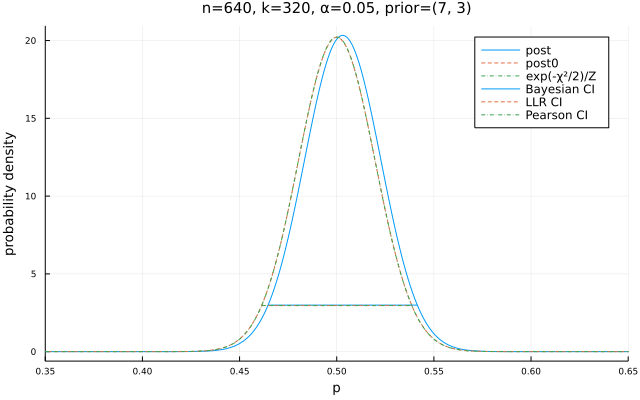

In [24]:
plot_paramdist(n=640, k=320, γ=7, δ=3, xlim=(0.35, 0.65))